In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import umap
import math
import numpy.linalg as la
#Fashion mnist
from sklearn import model_selection
from sklearn import linear_model, ensemble, tree, neighbors, svm
from mnist.loader import MNIST
from sklearn.decomposition import PCA

In [2]:
print("Fetching Fashion-Mnist")
print("=========================")
mndata = MNIST('../fashion-mnist/data/fashion') #added path extension for new file structure
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser', 
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']
print("Fashion-Mnist loaded")
print ("=========================")

Fetching Fashion-Mnist
Fashion-Mnist loaded


## Compeltion Bar

In [4]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

## Rotation Function via openCV

In [5]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse

In [6]:
def rotate(image, deg):
    src=image
    srcTri = np.array( [[0, 0], [src.shape[1] - 1, 0], [0, src.shape[0] - 1]] ).astype(np.float32)
    dstTri = np.array( [[0, src.shape[1]*0.33], [src.shape[1]*0.85, src.shape[0]*0.25], [src.shape[1]*0.15, src.shape[0]*0.7]] ).astype(np.float32)
    warp_mat = cv.getAffineTransform(srcTri, dstTri)
    warp_dst = cv.warpAffine(src, warp_mat, (src.shape[1], src.shape[0]))

    # Rotating the image after Warp
    center = (warp_dst.shape[1]//2, warp_dst.shape[0]//2)
    angle = deg
    scale = 1

    rot_mat = cv.getRotationMatrix2D( center, angle, scale )
    warp_rotate_dst = cv.warpAffine(src, rot_mat, (src.shape[1], src.shape[0]))
    tau=.1
    for j in range(warp_rotate_dst.shape[0]):
        for k in range(warp_rotate_dst.shape[0]):
            if warp_rotate_dst[j][k]<tau:
                warp_rotate_dst[j][k]=np.rint(warp_rotate_dst[j][k])
    return warp_rotate_dst

## Rotating Data Set by random amounts

In [44]:
#Generate list of rotations to randomly choose from 
N=10
phi = np.linspace(-N,N,1000)
phi = phi%(2*math.pi)
phi=np.degrees(phi)
phi=(np.floor(phi))
phi=phi.astype('int32')
print(np.random.choice(phi))

r_data=[]
for i in range(np.shape(data)[0]):
    theta=np.random.choice(phi)
    #print(i,theta)
    r_data.append(rotate(np.reshape(data[i],(28,28)),theta))
    update_progress(i / np.shape(data)[0])
    

Progress: [####################] 100.0%


## Inverse rotation computation and helper functions

In [216]:
def compute_principal_vectors(A):
    Y=compute_mask(A.T)
    n=np.shape(A)[0]        
    X=compute_pointset(Y,n)
    
    #compute Correlation matrix 
    C=1/n*X@X.T
    w,v=la.eig(C)
    # Determine which eigenvalue is the negative one for correlation matrix construction 
    if(w[0]<w[1]):
        neg_eig=w[0]
        pos_eig=w[1]
    else:
        neg_eig=w[1]
        pos_eig=w[0]
        
    #Manually generate matrix using enteries of correlation matrix(possible errors on addition of negative eigenvalue to wrong index)
    Vplus=np.asarray([C[0][0]+C[0][1]-neg_eig,C[1][1]+C[0][1]-neg_eig])
    Vminus=np.asarray([C[0][0]+C[0][1]-pos_eig,C[1][1]+C[0][1]-pos_eig]) 
    
    #original construction of special eigenvectors 
    #Vplus=np.asarray([C[0][0]+C[0][1]-w[0],C[1][1]+C[0][1]-w[0]])
    #Vminus=np.asarray([C[0][0]+C[0][1]-w[1],C[1][1]+C[0][1]-w[1]])
      
    Uplus=Vplus / np.sqrt(np.sum(Vplus**2))
    Uminus=Vminus / np.sqrt(np.sum(Vminus**2))
    Rtrans=np.column_stack(((Uplus),(Uminus)))
    return Rtrans,X


In [275]:
def compute_principal_vectors_from_pointset(X):
    #compute Correlation matrix 
    C=1/28*X@X.T
    w,v=la.eig(C)
    # Determine which eigenvalue is the negative one for correlation matrix construction 
    if(w[0]<w[1]):
        neg_eig=w[0]
        pos_eig=w[1]
    else:
        neg_eig=w[1]
        pos_eig=w[0]
        
    #Manually generate matrix using enteries of correlation matrix(possible errors on addition of negative eigenvalue to wrong index)
    Vplus=np.asarray([C[0][0]+C[0][1]-neg_eig,C[1][1]+C[0][1]-neg_eig])
    Vminus=np.asarray([C[0][0]+C[0][1]-pos_eig,C[1][1]+C[0][1]-pos_eig]) 
    
    #original construction of special eigenvectors 
    #Vplus=np.asarray([C[0][0]+C[0][1]-w[0],C[1][1]+C[0][1]-w[0]])
    #Vminus=np.asarray([C[0][0]+C[0][1]-w[1],C[1][1]+C[0][1]-w[1]])
      
    Uplus=Vplus / np.sqrt(np.sum(Vplus**2))
    Uminus=Vminus / np.sqrt(np.sum(Vminus**2))
    Rtrans=np.column_stack(((Uplus),(Uminus)))
    return Rtrans,X

In [217]:
def compute_mask(A):
    n=np.shape(A)[0]
    Y=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if A[i][j]>.025:
                Y[i][j]=1
    #small corrections to mask quality 
    for i in range(n):
        for j in range(n):
            if i==n-1 or j==n-1:
                continue
            #Check neighbors
            if Y[i-1][j]+Y[i+1][j]+Y[i][j-1]+Y[i][j+1]==3:     #try maxing or averaging over threshold 
                Y[i][j]=1
    return Y

In [218]:
def compute_pointset(Y,n):
    #Create point list for 2d pca
    x=[]
    y=[]
    for i in range(n):
        for j in range(n):
            if Y[i][j]==1:
                x.append(i)
                y.append(j)
    return np.vstack((x,y))

In [219]:
def inverse_degrees(Rtrans):
    theta=math.degrees(math.acos(Rtrans[0][0]))
    return theta

## Plotting Functions

In [220]:
def plot_pc_vectors(R,X):
    #Manual image reflection: 
    fig = plt.figure( figsize=(8, 6))
    plt.plot(X[0,:],X[1,:],'o')

    origin = [15, 15]
    plt.quiver(*origin, R[0][0],R[0][1],  color=['r'], scale=1)
    plt.quiver(*origin, R[1][0],R[1][1],color=['y'], scale=1)

    
    #uncomment for full axis 
    #origin = [15, 15]
    #plt.quiver(*origin, -R[0][0],-R[0][1],  color=['r'], scale=1)
    #plt.quiver(*origin, -R[1][0],-R[1][1],color=['y'], scale=1)
    plt.title("Plot of pca vectors of image matrix over 2d binary mask interpretation")
    plt.xlabel('row') 
    plt.ylabel('column') 
    plt.show()
   
    #print(np.cross(Uplus,Uminus))

In [221]:
def compare_samples(control,rotated,corrected):
    #control
    fig = plt.figure( figsize=(8, 6))
    plt.title(" control ")
    plt.imshow(np.reshape(control,(28,28)), cmap='gray')
    plt.show()
    #Augmented
    fig = plt.figure( figsize=(8, 6))
    plt.title("augmented")
    plt.imshow(rotated, cmap='gray')
    plt.show()
    #correction: 
    fig = plt.figure( figsize=(8, 6))
    plt.title("corrected")
    plt.imshow(corrected, cmap='gray')
   # plt.imshow(rotate(r_data[n],theta), cmap='gray')
    plt.show()

## Testing on a single sample

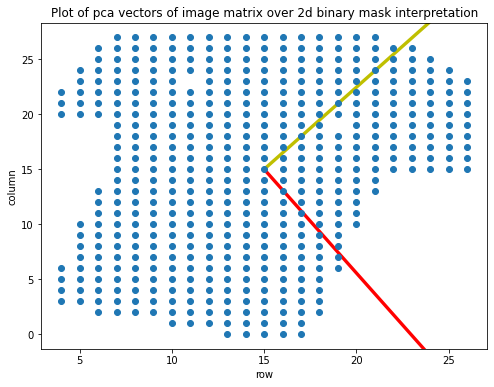

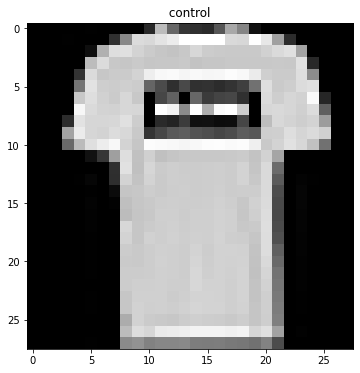

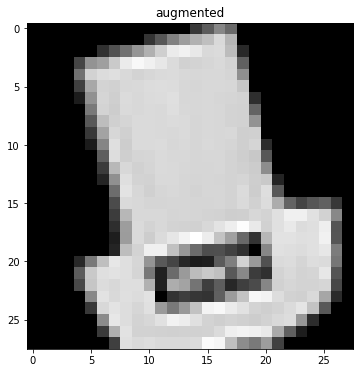

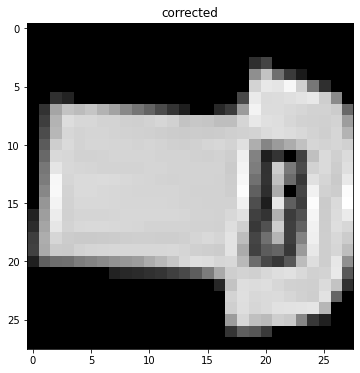

In [308]:
s=1
sample=np.reshape(data[s],(28,28))
R,X=compute_principal_vectors(r_data[s])
plot_pc_vectors(R,X)
t=inverse_degrees(R)
compare_samples(sample,r_data[s],rotate(sample,theta))

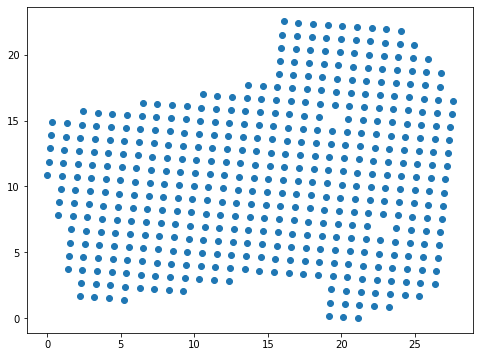

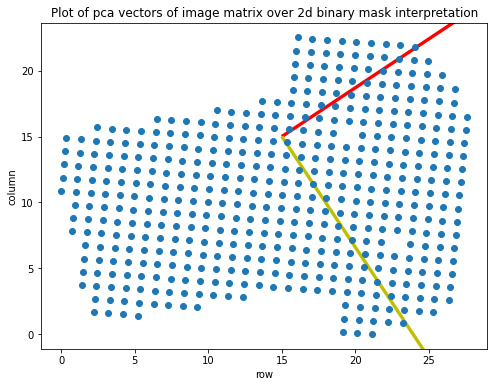

22.526522023765718
942


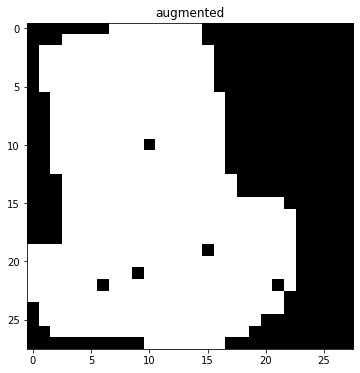

In [305]:
inverse_rotation=la.inv(R)
corrected_pointset=inverse_rotation@X
#print(type(corrected_pointset))
#print(min(corrected_pointset[0]))
##print(np.shape(corrected_pointset)[1])
minx=min(corrected_pointset[0])
for i in range(np.shape(corrected_pointset)[1]):
    corrected_pointset[0][i]=corrected_pointset[0][i]-minx
miny=min(corrected_pointset[1])
for i in range(np.shape(corrected_pointset)[1]):
    corrected_pointset[1][i]=corrected_pointset[1][i]-miny
    
    
fig = plt.figure( figsize=(8, 6))
plt.plot(corrected_pointset[0,:],corrected_pointset[1,:],'o')
#print(type(X))
R,X=compute_principal_vectors_from_pointset(corrected_pointset)
plot_pc_vectors(R,corrected_pointset)
print(max(corrected_pointset[1]))
corrected_pointset=np.floor(corrected_pointset)

#Manually re construct matrix from mask 
P=np.zeros((28,28))

print(np.size(corrected_pointset))
for i in range(np.shape(corrected_pointset)[1]):
    x=int(corrected_pointset[0][i])
    y=int(corrected_pointset[1][i])
    if (x>=28 or y>=28):
        continue
    P[x][y]=1
fig = plt.figure( figsize=(8, 6))
plt.title("augmented")
plt.imshow(P, cmap='gray')
plt.show()    

In [268]:
inverse_rotation=la.inv(R)
t=inverse_degrees(inverse_rotation)


error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/imgwarp.cpp:1800: error: (-215:Assertion failed) ifunc != 0 in function 'remap'


[[ 0.69444034 -0.71955029]
 [ 0.71955029  0.69444034]]
46.017363841342885


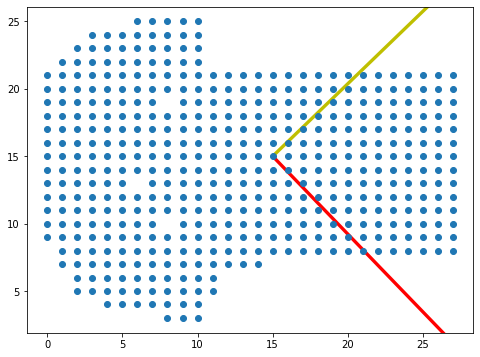

In [243]:
s=1
sample=np.reshape(data[s],(28,28))
Y=compute_mask(sample)
X=compute_pointset(Y,28)
#compute Correlation matrix 
C=1/28*X@X.T
w,v=la.eig(C)
# Determine which eigenvalue is the negative one for correlation matrix construction 
if(w[0]<w[1]):
    neg_eig=w[0]
    pos_eig=w[1]
else:
    neg_eig=w[1]
    pos_eig=w[0]

#Manually generate matrix using enteries of correlation matrix(possible errors on addition of negative eigenvalue to wrong index)
Vplus=np.asarray([C[0][0]+C[0][1]-neg_eig,C[1][1]+C[0][1]-neg_eig])
Vminus=np.asarray([C[0][0]+C[0][1]-pos_eig,C[1][1]+C[0][1]-pos_eig]) 

#original construction of special eigenvectors 
#Vplus=np.asarray([C[0][0]+C[0][1]-w[0],C[1][1]+C[0][1]-w[0]])
#Vminus=np.asarray([C[0][0]+C[0][1]-w[1],C[1][1]+C[0][1]-w[1]])

Uplus=Vplus / np.sqrt(np.sum(Vplus**2))
Uminus=Vminus / np.sqrt(np.sum(Vminus**2))
Rtrans=np.column_stack(((Uplus),(Uminus)))
print(Rtrans)

fig = plt.figure( figsize=(8, 6))
plt.plot(X[0,:],X[1,:],'o')

origin = [15, 15]
plt.quiver(*origin, Rtrans[0][0],Rtrans[0][1],  color=['r'], scale=1)
plt.quiver(*origin, Rtrans[1][0],Rtrans[1][1],color=['y'], scale=1)
t=inverse_degrees(Rtrans)
print(t)

It appears the normal form is actually 45 degrees not identity?

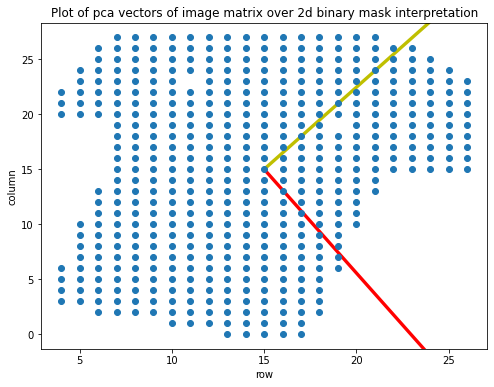

In [244]:
R,X=compute_principal_vectors(r_data[s])
plot_pc_vectors(R,X)

In [225]:
inverse_rotation=la.inv(R)
t=inverse_degrees(inverse_rotation)
rotated_mask=inverse_rotation@X
print(inverse_rotation)
print(t)

[[ 0.66439675  0.74738006]
 [-0.74738006  0.66439675]]
48.36393770144877


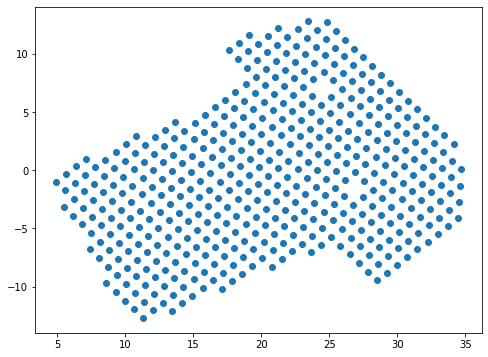

In [163]:
fig = plt.figure( figsize=(8, 6))
plt.plot(rotated_mask[0,:],rotated_mask[1,:],'o')

In [164]:
C=1/np.shape(rotated_mask)[1]*rotated_mask@rotated_mask.T
w,v=la.eig(C)
# Determine which eigenvalue is the negative one for correlation matrix construction 
if(w[0]<w[1]):
    neg_eig=w[0]
    pos_eig=w[1]
else:
    neg_eig=w[1]
    pos_eig=w[0]

#Manually generate matrix using enteries of correlation matrix(possible errors on addition of negative eigenvalue to wrong index)
Vplus=np.asarray([C[0][0]+C[0][1]-neg_eig,C[1][1]+C[0][1]-neg_eig])
Vminus=np.asarray([C[0][0]+C[0][1]-pos_eig,C[1][1]+C[0][1]-pos_eig]) 

#original construction of special eigenvectors 
#Vplus=np.asarray([C[0][0]+C[0][1]-w[0],C[1][1]+C[0][1]-w[0]])
#Vminus=np.asarray([C[0][0]+C[0][1]-w[1],C[1][1]+C[0][1]-w[1]])

Uplus=Vplus / np.sqrt(np.sum(Vplus**2))
Uminus=Vminus / np.sqrt(np.sum(Vminus**2))
Rtrans=np.column_stack(((Uplus),-(Uminus)))

[[ 1.00000000e+00  2.55142244e-16]
 [-2.87035024e-16  1.00000000e+00]]


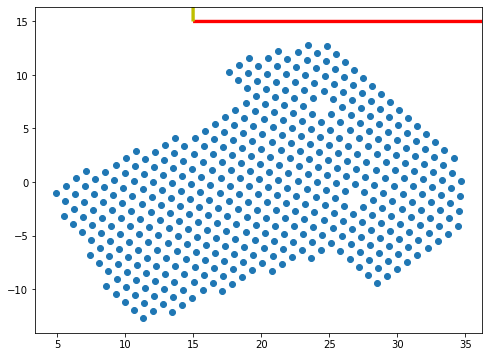

In [165]:
fig = plt.figure( figsize=(8, 6))
plt.plot(rotated_mask[0,:],rotated_mask[1,:],'o')
origin = [15, 15]
plt.quiver(*origin, Rtrans[0][0],Rtrans[0][1],  color=['r'], scale=1)
plt.quiver(*origin, Rtrans[1][0],Rtrans[1][1],color=['y'], scale=1)
print(Rtrans)

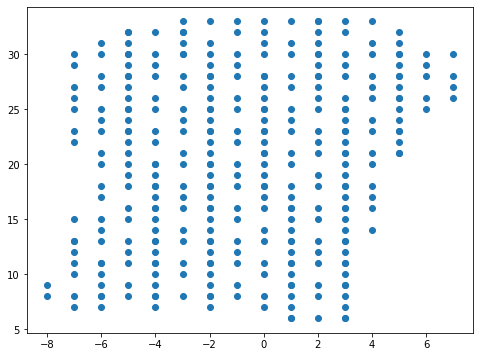

## Experimenting with the full pca 

In [186]:
pca=PCA(n_components=28, svd_solver='arpack')
pca.fit(r_data[s])

ValueError: n_components=28 must be strictly less than min(n_samples, n_features)=28 with svd_solver='arpack'

In [185]:
print(pca.components_)
print(pca.explained_variance_)

[[ 0.          0.          0.          0.          0.00467482  0.0189849
  -0.00285074 -0.03665262  0.02490196  0.04707306 -0.00107665 -0.13402013
  -0.1023189  -0.10294881 -0.11657011 -0.13536754 -0.11549859 -0.1129203
   0.00342775  0.0830618   0.22711417  0.39976176  0.4207045   0.41083542
   0.40376647  0.38206309  0.1591139   0.        ]
 [ 0.          0.          0.          0.          0.06401389  0.14145851
   0.0540939  -0.11584721 -0.23411655 -0.2417772  -0.25182097 -0.30763776
  -0.2426861  -0.23909529 -0.21001264 -0.20565494 -0.14586785 -0.20648815
  -0.35785298 -0.40368442 -0.32887668 -0.12370576 -0.06620432 -0.02714619
   0.01490784  0.04216657  0.01559597  0.        ]]
[0.84811047 0.41302765]
